# **3η Εργαστηριακή Άσκηση στα Νευρωνικά Δικτύα - Deep Learning - Image Captioning**

* Πάλμος Στέφανος 03118185
* Νικόλαρος Ανδρέας 03118401
* Ντάγκας Παναγιώτης 03118018

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/NN_Team13_Lab3

MY_PATH = '/content/drive/MyDrive/NN_Team13_Lab3/'

Mounted at /content/drive
/content/drive/MyDrive/NN_Team13_Lab3


In [ ]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'apt autoremove' to remove it.
The following packages will be REMOVED:
  libcudnn8-dev
The following held packages will be changed:
  libcudnn8
The following packages will be DOWNGRADED:
  libcudnn8
0 upgraded, 0 newly installed, 1 downgraded, 1 to remove and 19 not upgraded.
Need to get 430 MB of archives.
After this operation, 1,383 MB disk space will be freed.
Get:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  libcudnn8 8.1.0.77-1+cuda11.2 [430 MB]
Fetched 430 MB in 8s (54.0 MB/s)
(Reading database ... 128126 files and directories currently installed.)
Removing libcudnn8-dev (8.4.0.27-1+cuda11.6) ...
update-alternatives: removing manually selected alternative - switching libcudnn to auto mode
dpkg: warning: downgrading libcudnn8 from 8.4.0.27-1+cuda11.6 to

In [ ]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 58.4 MB/s eta 0:00:00


In [ ]:
!pip install einops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 2.3 MB/s eta 0:00:00


In [ ]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

import copy 

## Dataset - flickr30k ecemod 

In [ ]:
image_folder = 'image_dir/'

In [ ]:
if not os.path.exists(MY_PATH + image_folder):
  image_zip = tf.keras.utils.get_file('flickr30k-images-ecemod.zip',
                                        cache_subdir=MY_PATH,
                                        origin='https://spartacus.1337.cx/flickr-mod/flickr30k-images-ecemod.zip',
                                        extract=True)
  os.remove(image_zip)

# Download train captions
train_files_list = tf.keras.utils.get_file('train_files.csv',
                                           cache_subdir=MY_PATH,
                                           origin='https://spartacus.1337.cx/flickr-mod/train_files.csv',
                                           extract=False)

# Download test files list
test_files_list = tf.keras.utils.get_file('test_files.csv',
                                           cache_subdir=MY_PATH,
                                           origin='https://spartacus.1337.cx/flickr-mod/test_files.csv',
                                           extract=False)
# Download captions file
captions_file = tf.keras.utils.get_file('captions_new.csv',
                                           cache_subdir=MY_PATH,
                                           origin='https://spartacus.1337.cx/flickr-mod/captions_new.csv',
                                           extract=False)

12186945/12186945 [==============================] - 3s 0us/step


Number of images in the Dataset: 31784
This is a sample image:


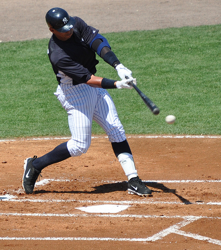

In [ ]:
print("Number of images in the Dataset: " + str(len(os.listdir(MY_PATH + image_folder))))
img = Image.open('image_dir/_1061948.jpg')
dims = img.size
sample_img = img.resize((dims[0]//2, dims[1]//2))
print("This is a sample image:")
sample_img

In [ ]:
from pathlib import Path
path = Path(MY_PATH)

In [ ]:
captions = (path/captions_file).read_text().splitlines()
captions = (line.split('\t') for line in captions)
captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

In [ ]:
train_files = (path/train_files_list).read_text().splitlines()
   
test_files = (path/test_files_list).read_text().splitlines()

In [ ]:
cap_dict = collections.defaultdict(list)
for fname, cap in captions:
  cap_dict[fname].append(cap)

In [ ]:
train_captions = [(str(path/image_folder/fname), cap_dict[fname]) for fname in train_files]
test_captions = [(str(path/image_folder/fname), cap_dict[fname]) for fname in test_files]

In [ ]:
train_captions_df = pd.DataFrame(train_captions)

train_captions_df.columns = ["File","Captions"]
display(train_captions_df.head(3))

File  \
0  /content/drive/MyDrive/NN_Team13_Lab3/image_di...   
1  /content/drive/MyDrive/NN_Team13_Lab3/image_di...   
2  /content/drive/MyDrive/NN_Team13_Lab3/image_di...   

                                            Captions  
0  [The skier is wearing a yellow jumpsuit and sl...  
1  [Two boys are in the foreground of a seashore ...  
2  [A man in jeans and a blue long-sleeved shirt ...

In [ ]:
test_captions_df = pd.DataFrame(test_captions)

test_captions_df.columns = ["File","Captions"]
display(test_captions_df.head(3))

File  \
0  /content/drive/MyDrive/NN_Team13_Lab3/image_di...   
1  /content/drive/MyDrive/NN_Team13_Lab3/image_di...   
2  /content/drive/MyDrive/NN_Team13_Lab3/image_di...   

                                            Captions  
0  [a black and white dog wearing a blue shirt ca...  
1  [A man wearing aqua pants and matching flip-fl...  
2  [a large bull targets a man , inches away , in...

In [ ]:
print("Train set length:", len(train_files))
print("Test set length:", len(test_files))

Train set length: 21000
Test set length: 4524


In [ ]:
train_raw = tf.data.experimental.from_list(train_captions)
test_raw = tf.data.experimental.from_list(test_captions)

In [ ]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

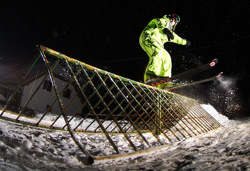

In [ ]:
#print("Number of images in the Dataset: " + str(len(os.listdir(MY_PATH + image_folder))))
img = Image.open('image_dir/_3430497.jpg')
dims = img.size
sample_img = img.resize((dims[0]//2, dims[1]//2))
sample_img

In [ ]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'/content/drive/MyDrive/NN_Team13_Lab3/image_dir/_3430497.jpg', shape=(), dtype=string)
tf.Tensor(
[b'The skier is wearing a yellow jumpsuit and sliding across a yellow rail .'
 b'A yellow uniformed skier is performing a trick across a railed object .'
 b'A skier in electric green on the edge of a ramp made of metal bars .'
 b'A person on skis on a rail at night .'
 b'A skier slides along a metal rail .'], shape=(5,), dtype=string)


## Image feature extractor

In [ ]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

4334752/4334752 [==============================] - 0s 0us/step


In [ ]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

In [ ]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)
(1, 7, 7, 576)


## Setup the text tokenizer/vectorizer

We will transform the text captions into integer sequences using the TextVectorization layer, with the following steps:

* Use adapt to iterate over all captions, split the captions into words, and compute a vocabulary of the top words.
* Tokenize all captions by mapping each word to its index in the vocabulary. All output sequences will be padded to length 50.
* Create word-to-index and index-to-word mappings to display results.

In [ ]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [ ]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [ ]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [ ]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'and', 'man']

In [ ]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 755, 5, 2, 63, 4], [3, 2, 2866, 34, 4]]>

In [ ]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [ ]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

## Prepare the datasets

The train_raw and test_raw datasets contain 1:many (image, captions) pairs.

This function will replicate the image so there are 1:1 images to captions:


In [ ]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [ ]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)

image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


To be compatible with keras training the dataset should contain (inputs, labels) pairs. For text generation the tokens are both an input and the labels, shifted by one step. This function will convert an (images, texts) pair to an ((images, input_tokens), label_tokens) pair:

In [ ]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

This function adds operations to a dataset. The steps are:

1. Load the images (and ignore images that fail to load).
2. Replicate images to match the number of captions.
3. Shuffle and rebatch the image, caption pairs.
4.Tokenize the text, shift the tokens and add label_tokens.
5. Convert the text from a RaggedTensor representation to padded dense Tensor representation.

In [ ]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

In [ ]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [ ]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

## [Optional] Cache the image features

Since the image feature extractor is not changing, and this tutorial is not using image augmentation, the image features can be cached. Same for the text tokenization. The time it takes to set up the cache is earned back on each epoch during training and validation. The code below defines two functions save_dataset and load_dataset:

In [ ]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU. 
  def gen():
    for (images, captions) in tqdm.tqdm(ds): 
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization 
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)
  
  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [ ]:
# save_dataset(train_raw, 'train_cache', mobilenet, tokenizer)
# save_dataset(test_raw, 'test_cache', mobilenet, tokenizer)

## Data ready for training

After those preprocessing steps, here are the datasets:

In [ ]:
# train_ds = load_dataset('train_cache')
# test_ds = load_dataset('test_cache')

In [ ]:
train_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

The dataset now returns (input, label) pairs suitable for training with keras. The inputs are (images, input_tokens) pairs. The images have been processed with the feature-extractor model. For each location in the input_tokens the model looks at the text so far and tries to predict the next which is lined up at the same location in the labels.

In [ ]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 224, 224, 3)
(32, 43)
(32, 43)


In [ ]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[   3    2   67 1588   10    5  415   92    2  206   70   72   22 1040
    5   19  309    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]
[   2   67 1588   10    5  415   92    2  206   70   72   22 1040    5
   19  309    4    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


## A Transformer decoder model 

The model will be implemented in three main parts: 

1. Input - The token embedding and positional encoding (`SeqEmbedding`).
1. Decoder - A stack of transformer decoder layers (`DecoderLayer`) where each contains:
   1. A causal self attention later (`CausalSelfAttention`), where each output location can attend to the output so far.
   1. A cross attention layer (`CrossAttention`) where each output location can attend to the input image.
   1. A feed forward network (`FeedForward`) layer which further processes each output location independently.
1. Output - A multiclass-classification over the output vocabulary.


### Input

The input text has already been split up into tokens and converted to sequences of IDs.

Remember that unlike a CNN or RNN the Transformer's attention layers are invariant to the order of the sequence. Without some positional input, it just sees an unordered set not a sequence. So in addition to a simple vector embedding for each token ID, the embedding layer will also include an embedding for each position in the sequence.

The SeqEmbedding layer defined below:

* It looks up the embedding vector for each token.
* It looks up an embedding vector for each sequence location.
* It adds the two together.
* It uses mask_zero=True to initialize the keras-masks for the model.

Note: This implementation learns the position embeddings instead of using fixed embeddings like in the Transformer tutorial. Learning the embeddings is slightly less code, but doesn't generalize to longer sequences.

In [ ]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)
    
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

### Decoder 

The decoder is a standard Transformer-decoder, it contains a stack of DecoderLayers where each contains three sublayers: a CausalSelfAttention, a CrossAttention, and a FeedForward.

The CausalSelfAttention layer is below:

In [ ]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)

The CrossAttention layer is below. Note the use of return_attention_scores.

In [ ]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

The `FeedForward` layer is below. Remember that a `layers.Dense` layer is applied to the last axis of the input. The input will have a shape of `(batch, sequence, channels)`, so it automatically applies pointwise across the `batch` and `sequence` axes.  

In [ ]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


Next arrange these three layers into a larger DecoderLayer. Each decoder layer applies the three smaller layers in sequence. After each sublayer the shape of out_seq is (batch, sequence, channels). The decoder layer also returns the attention_scores for later visualizations.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### Output

At minimum the output layer needs a `layers.Dense` layer to generate logit-predictions for each token at each location.

But there are a few other features you can add to make this work a little better:

1. **Handle bad tokens**: The model will be generating text. It should
   never generate a pad, unknown, or start token (`''`, `'[UNK]'`, 
   `'[START]'`). So set the bias for these to a large negative value.

   > Note: You'll need to ignore these tokens in the loss function as well. 

2. **Smart initialization**: The default initialization of a dense layer will
  give a model that initially predicts each token with almost uniform
  likelihood. The actual token distribution is far from uniform. The
  optimal value for the initial bias of the output layer is the log of the
  probability of each token. So include an `adapt` method to count the tokens
  and set the optimal initial bias. This reduces the initial loss from the
  entropy of the uniform distribution (`log(vocabulary_size)`) to the marginal
  entropy of the distribution (`-p*log(p)`).


In [ ]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


In [ ]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

3282it [1:18:12,  1.43s/it]


Uniform entropy: 8.52
Marginal entropy: 5.47


### Build the model

To build the model, you need to combine several parts:

1. The image `feature_extractor` and the text `tokenizer` and.
1. The `seq_embedding` layer, to convert batches of token-IDs to 
   vectors `(batch, sequence, channels)`.
3. The stack of `DecoderLayers` layers that will process the text and image data.
4. The `output_layer` which returns a pointwise prediction of what the next word should be.

In [ ]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

When you call the model, for training, it receives an `image, txt` pair. To make this function more usable, be flexible about the input:

* If the image has 3 channels run it through the feature_extractor. Otherwise assume that it has been already. Similarly
* If the text has dtype `tf.string` run it through the tokenizer.

After that running the model is only a few steps:

1. Flatten the extracted image features, so they can be input to the decoder layers.
2. Look up the token embeddings.
3. Run the stack of `DecoderLayer`s, on the image features and text embeddings.
4. Run the output layer to predict the next token at each position.

In [ ]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = self.tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

In [ ]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

### Generate captions

Before getting into training, write a bit of code to generate captions. You'll use this to see how training is progressing.

Start by downloading a test image:

In [ ]:
image = load_image('/content/drive/MyDrive/NN_Team13_Lab3/image_dir/_626869.jpg')
print(image.shape)

(224, 224, 3)


In [ ]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = self.index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

In [ ]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

a a
a a a
fish in gliding running blue he man looking black people holds sitting people in curious blondhair starts table crowd a her men multiple on bass playing a busy with on hot with getting in is is balloon wearing wearing man playing woman runs a white gold walking and group


## Train

To train the model you'll need several additional components:

- The Loss and metrics
- The Optimizer
- Optional Callbacks

### Losses and metrics

In [ ]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### Callbacks

In [ ]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_path = '/content/drive/MyDrive/NN_Team13_Lab3/image_dir/_626869.jpg'
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()


In [ ]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)



a a
a
two lunges is shirt is the background a



In [ ]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

### Train

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

In [ ]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 5.2655 - masked_acc: 0.1834

a man in a man in a man in a man
a man and a a a a boy
water plays with is street riding on white campfire green corn as biting is crew

100/100 [==============================] - 185s 2s/step - loss: 5.2655 - masked_acc: 0.1834 - val_loss: 4.9268 - val_masked_acc: 0.2235
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 4.8638 - masked_acc: 0.2312

a man in a man in a man in a man
a woman in a blue dog
bath man wearing stage

100/100 [==============================] - 156s 2s/step - loss: 4.8638 - masked_acc: 0.2312 - val_loss: 4.6676 - val_masked_acc: 0.2479
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 4.6751 - masked_acc: 0.2526

a dog is in a blue shirt is in a dog
a dog is sitting on the water
two women of his runs races a white blue dog building in white white riding up child in two sponge stand

100/100 [==============================

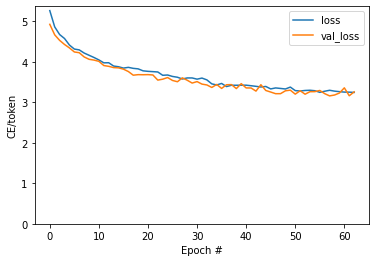

In [ ]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

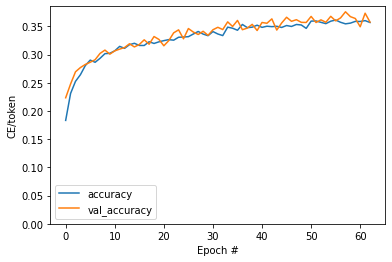

In [ ]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## Attention plots

In [ ]:
result = model.simple_gen(image, temperature=0.0)
result

'a dog runs through a field'

Split the output back into tokens:

In [ ]:
str_tokens = result.split()
str_tokens.append('[END]')

The `DecoderLayers` each cache the attention scores for their `CrossAttention` layer. The shape of each attention map is `(batch=1, heads, sequence, image)`:

In [ ]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 7, 49]), TensorShape([1, 2, 7, 49])]

In [ ]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

In [ ]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(7,), dtype=float32, numpy=
array([1.        , 1.        , 0.99999994, 1.        , 1.        ,
       1.        , 1.        ], dtype=float32)>

In [ ]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

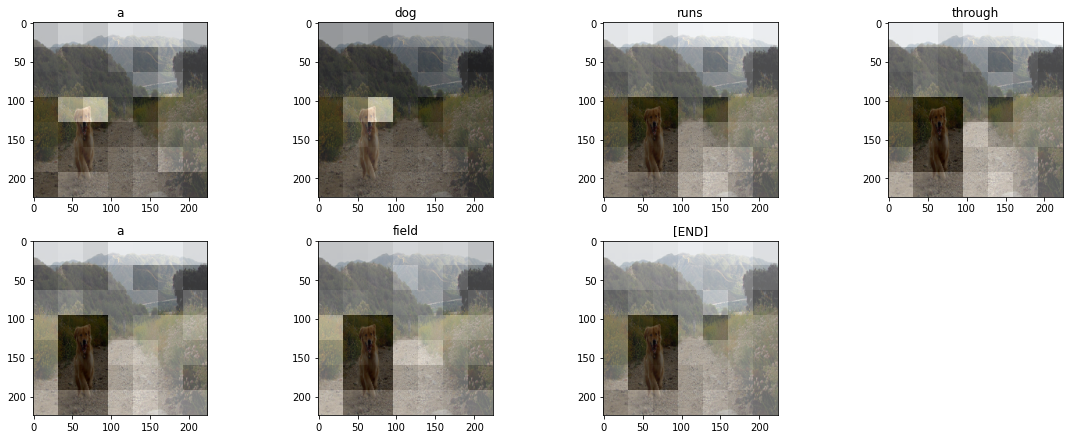

In [ ]:
plot_attention_maps(image/255, str_tokens, attention_maps)

In [ ]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)

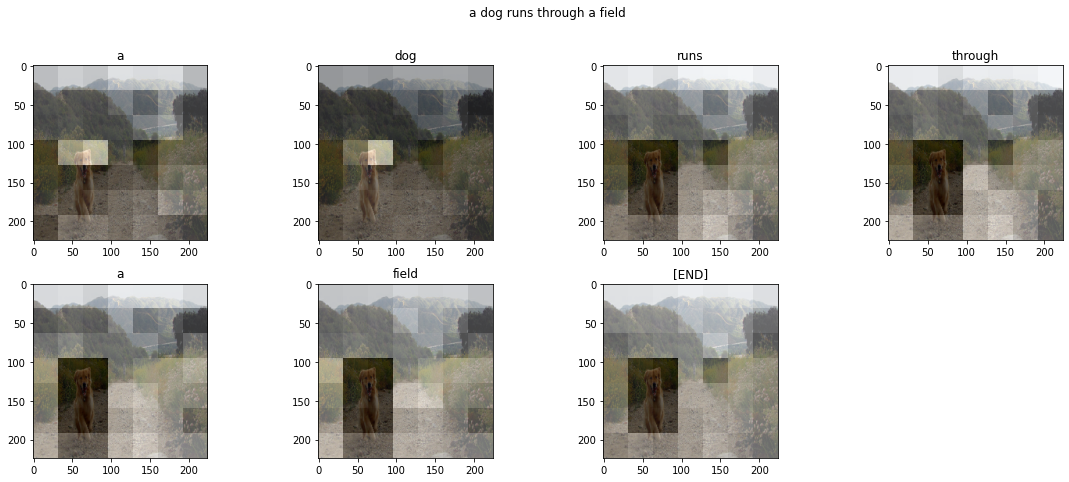

In [ ]:
run_and_show_attention(model, image)

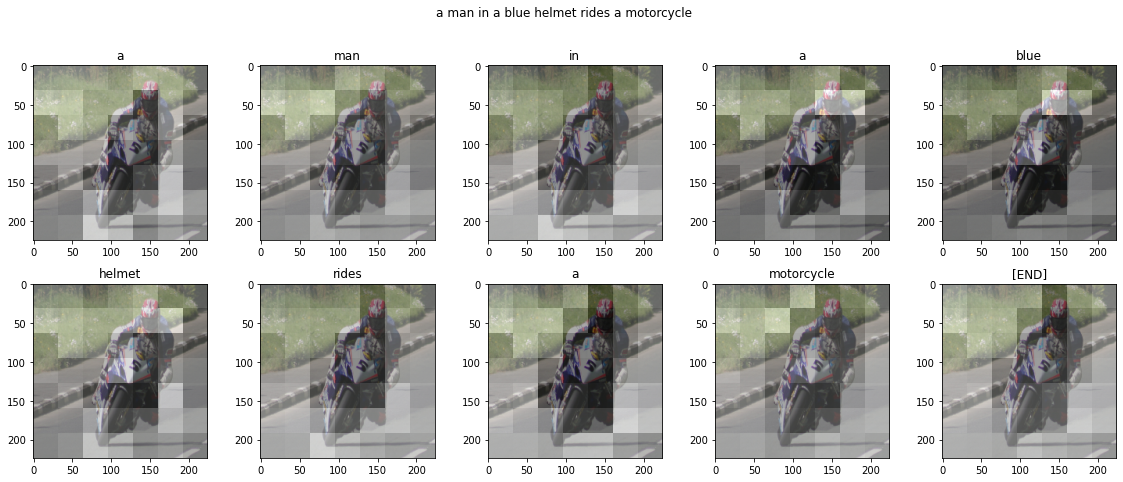

In [ ]:
image = load_image('/content/drive/MyDrive/NN_Team13_Lab3/image_dir/_866946.jpg')
run_and_show_attention(model, image)

64400/64400 [==============================] - 0s 1us/step


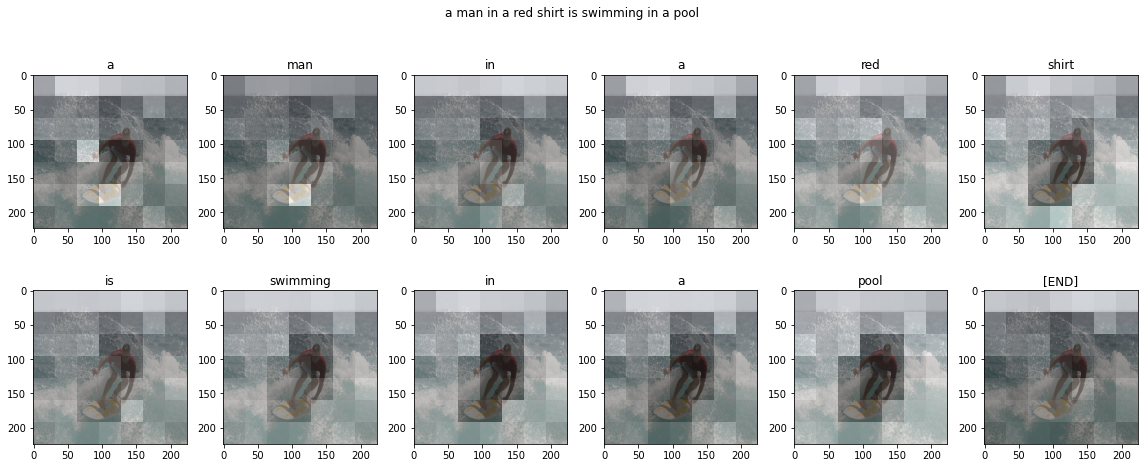

In [ ]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)
run_and_show_attention(model, image)

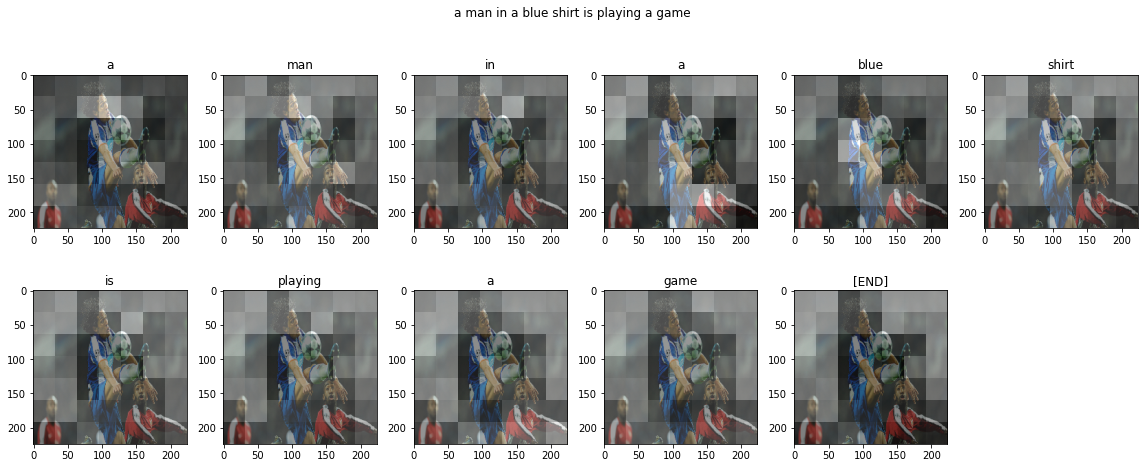

In [ ]:
image = load_image('/content/drive/MyDrive/NN_Team13_Lab3/image_dir/_1127412.jpg')
run_and_show_attention(model, image)

A bunch of people are standing all together in a street with a building in the background .
A blond woman in a blue jacket is holding up a pillow in a red pillowcase .
A large crowd has a few people lifting pillowcases over their heads .
people , outside , throwing stuff over the top of them .
People are engaged in a public pillow fight .


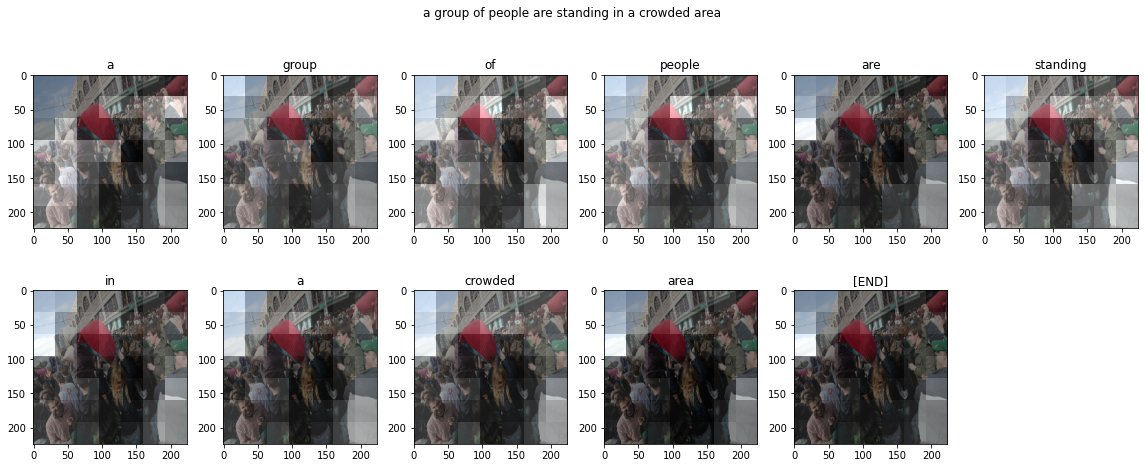

In [ ]:
image = load_image('image_dir/' +train_files[122])
for caption in train_captions[122][1]:
  print(caption)
run_and_show_attention(model, image)

## BLEU Score

In [ ]:
import nltk.translate.bleu_score as bleu_score
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu, SmoothingFunction
from tqdm import notebook

In [ ]:
weights = (0.4, 0.3, 0.2, 0.1)
smoothing_function = SmoothingFunction().method1

In [ ]:
def sent_bleu(image_file, ref_file, model, type_=0, b=3):
  image = load_image('image_dir/' + image_file)
  if(type_ == -1):
    hypothesis = model.simple_gen(image, -1, b)
  else:
    hypothesis = model.simple_gen(image, type_)
  sent1 = hypothesis.split()
  ref_list = []
  for ref in ref_file[1]:
    ref1 = ref.split()
    ref1 = ref1[:-1]
    ref_list.append(ref1)
  
  bleu_score = sentence_bleu(ref_list, sent1, weights, smoothing_function)
  print("Bleu score for image " + str(image_file) + " : " + str(bleu_score))
  return bleu_score

In [ ]:
sent_bleu(test_files[20], test_captions[20], model)

Bleu score for image _371754536.jpg : 0.4968227501792918


0.4968227501792918

In [ ]:
#extra

sent_bleu(test_files[20], test_captions[20], model)

Bleu score for image _371754536.jpg : 0.13163497310232847


0.13163497310232847

In [ ]:
def Bleu_evaluation(image_set, ref_set, model, type_=0, b=3):
  print("####### BLEU Metric for Model Evaluation #######")
  hypothesis_list = []
  ref_list = []
  for i,image in notebook.tqdm(enumerate(image_set)):
    image = load_image('image_dir/' + image)
    if (type_==-1):
      hypothesis = model.simple_gen(image, -1, b)
    else:
      hypothesis = model.simple_gen(image, type_)
    sent1 = hypothesis.split()
    hypothesis_list.append(sent1)
    ref_image = []
    for ref in ref_set[i][1]:
      clean_ref = ref.split()[:-1]
      ref_image.append(clean_ref)
    ref_list.append(ref_image)
  bleu_score = corpus_bleu(ref_list, hypothesis_list, weights, smoothing_function)
  print("Bleu Score of the model is:", bleu_score)
  return bleu_score

In [ ]:
Bleu_evaluation(test_files, test_captions, model)

####### BLEU Metric for Model Evaluation #######


4524it [1:07:35,  1.12it/s]


Bleu Score of the model is: 0.22087558507463195


0.22087558507463195

In [ ]:
#extra

Bleu_evaluation(test_files[:1000], test_captions[:1000], model)

####### BLEU Metric for Model Evaluation #######


0it [00:00, ?it/s]

Bleu Score of the model is: 0.1314132065938174


0.1314132065938174

## **Βελτιώσεις**

***Σημείωση:*** *Τα τρεξίματα έγιναν σπαστά από τα μέλη της ομάδας λόγω του χρόνου που χρείαζονταν*

### Encoder

Σε αυτο το σημείο δοκιμάζουμε διάφορα μοντέλα από το Keras που μας δόθηκε στην εκφώνηση της άσκησης και επιλέγουμε αυτά που έχουν το βέλτιστο συνδυασμό του χρόνου εκτέλεσης και του Bleu Score

In [ ]:
IMAGE_SHAPE=(224, 224, 3)
efficientnet = tf.keras.applications.EfficientNetV2S(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
efficientnet.trainable=False

82420632/82420632 [==============================] - 1s 0us/step


In [ ]:
model2 = Captioner(tokenizer, feature_extractor=efficientnet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

In [ ]:
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

In [ ]:
history2 = model2.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 5.1917 - masked_acc: 0.1913

a man in a man in a man
a man in a in the of a are
little dance is shirt on a white front looking

100/100 [==============================] - 72s 453ms/step - loss: 5.1917 - masked_acc: 0.1913 - val_loss: 5.0115 - val_masked_acc: 0.2188
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 4.8673 - masked_acc: 0.2376

a man in a white shirt and a man in a man in a man in a man in a man in a man in a man
a man in a red shirt in a man in a woman
people man a man black dog and on a leather and filled for a swinging and a stands the head in a yard ocean

100/100 [==============================] - 29s 291ms/step - loss: 4.8673 - masked_acc: 0.2376 - val_loss: 4.6608 - val_masked_acc: 0.2513
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 4.7087 - masked_acc: 0.2491

a man in a black shirt and a man in a man in a man
a woman in the man in a black dog
peo

In [ ]:
Bleu_evaluation(test_files, test_captions, model2)

####### BLEU Metric for Model Evaluation #######


4524it [1:38:53,  1.31s/it]


Bleu Score of the model is: 0.1553329999385692


0.1553329999385692

In [ ]:
IMAGE_SHAPE=(224, 224, 3)
efficientnetB5 = tf.keras.applications.EfficientNetB5(
    input_shape=IMAGE_SHAPE,
    include_top=False)
efficientnetB5.trainable=False

115263384/115263384 [==============================] - 4s 0us/step


In [ ]:
model3 = Captioner(tokenizer, feature_extractor=efficientnetB5, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])
history3 = model3.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 4.8912 - masked_acc: 0.1998

a man in a black shirt is in a white dog
a man in a red and a beach
two young boy girls up one object lovely each next building

100/100 [==============================] - 73s 479ms/step - loss: 4.8912 - masked_acc: 0.1998 - val_loss: 4.4582 - val_masked_acc: 0.2460
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 4.4189 - masked_acc: 0.2544

a man in a red shirt is playing a red shirt and a red shirt
a little girl with a red
a person wearing a pool at a tongue behind

100/100 [==============================] - 39s 395ms/step - loss: 4.4189 - masked_acc: 0.2544 - val_loss: 4.2644 - val_masked_acc: 0.2675
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 4.2671 - masked_acc: 0.2683

a dog is running on a beach
the dog in a black shirt is playing and red dog
a woman a small long distance

100/100 [==============================] - 34s 337ms/step -

In [ ]:
Bleu_evaluation(test_files[:1000], test_captions[:1000], model3)

####### BLEU Metric for Model Evaluation #######


1000it [32:56,  1.98s/it]


Bleu Score of the model is: 0.09322853099166352


0.09322853099166352

In [ ]:
model4 = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

model4.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])
history4 = model4.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 5.2155 - masked_acc: 0.1911

a man in a man in a
a man in a a man in a and a
a in red alley wearing the the noses the sitting while statue walk at longhaired is building

100/100 [==============================] - 254s 2s/step - loss: 5.2155 - masked_acc: 0.1911 - val_loss: 4.9466 - val_masked_acc: 0.2209
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 4.9112 - masked_acc: 0.2289

a man in a dog in a dog
two people in a white dog in a dog
a kinds young and a street flower of a walls on red to the of the inflatable the in the the street clothes guy on a mouth in the in front

100/100 [==============================] - 159s 2s/step - loss: 4.9112 - masked_acc: 0.2289 - val_loss: 4.8156 - val_masked_acc: 0.2402
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 4.6873 - masked_acc: 0.2554

a man is in a dog is on a dog
a dog is standing in a dog
a which young man up a running 

In [ ]:
Bleu_evaluation(test_files[:1000], test_captions[:1000], model4)

####### BLEU Metric for Model Evaluation #######


0it [00:00, ?it/s]

Bleu Score of the model is: 0.18699598657038222


0.18699598657038222

Keras Models  |  Performance(Runtime, Bleu)
-------------------|------------------
Mobilenet          | Bleu: 0.187
EfficientnetV2S    | Bleu: 0.155
EfficientnetV2M    | Bleu: 0.134
EfficientnetV2L    | Bleu: 0.141 και αρκετά αργό
EfficientnetB25    | Bleu: 0.093
ConvNeXtLarge      | Υπερβολικά Αργό χωρίς ιδιαίτερη βελτίωση
ConvNeXtXLarge     | Αντίστοιχα με το Large και ακόμα πιο αργό

Επιλέγουμε, έτσι, να συνεχίσουμε χρησιμοποιώντας τα Mobilenet και EfficientnetV2S στα επόμενα βήματα.

### Προεπεξεργασία κειμένου

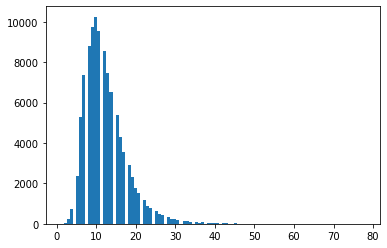

In [ ]:
capt_lengths = []
for image in train_captions:
  for caption in image[1]:
    clean_capt = caption.split()[:-1]
    capt_lengths.append(len(clean_capt)) 


plt.figure()
plt.hist(capt_lengths, bins=100)
plt.show()

Αρχικά προσπαθήσαμε να κόψουμε κάποια μικρά και μεγάλα captions και φτιάξαμε ξανά το train_raw_clean ώστε να έχουμε μια πιο ομαλή κατανομή των lengths των captions. Επιλέξαμε συγκεκριμένα threshold min = 5 και max = 20, διότι όπως βλέπουμε από το παραπάνω διάγραμμα εκεί κυμαίνεται το όριο μεγέθους των περισσότερο συχνά χρησιμοποιούμενων λέξεων.

In [ ]:
threshold_min = 5
threshold_max = 20

In [ ]:
train_captions_clean = []

for image in train_captions:
  flag = False
  clean_capts = []
  for caption in image[1]:
    clean_capt = caption.split()[:-1]
    if (len(clean_capt) >= threshold_min and len(clean_capt) < threshold_max):
      flag = True
      clean_capts.append(caption)
  if(flag):
    train_captions_clean.append((image[0], clean_capts))


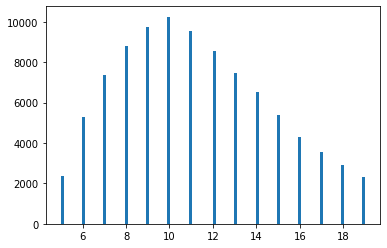

In [ ]:
capt_lengths = []
for image in train_captions_clean:
  for caption in image[1]:
    clean_capt = caption.split()[:-1]
    capt_lengths.append(len(clean_capt)) 


plt.figure()
plt.hist(capt_lengths, bins=100)
plt.show()

In [ ]:
train_raw_clean = tf.data.experimental.from_list(train_captions_clean)
train_raw_clean.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(None,), dtype=tf.string, name=None))

Υπήρχε πρόβλημα όμως με τον έτοιμο κώδικο του tf και το fit δεν λειτουργούσε. Το ερώτημα αφαιρέθηκε εντελώς από την εργασία με οδηγία των διδασκόντων, παρ' όλα αυτά θεωρούμε ότι θα βοηθούσε στη βελτίωση.
**Δεν συνεχίζουμε με αυτό!**

Στη συνέχεια φτιάχνουμε την new_standardize στην οποία προσθέσαμε 2 λειτουργίες:

1. Σπάει κάποιες ενωμένες λέξεις με αποστρόφους σε 2 λέξεις ώστε να φαίνεται καλύτερα η σημασιολογία καθώς παρατηρήσαμε ότι υπάρχουν πολλές τέτοιες περιπτώσεις.
2. Αλλάζει τους νουμερικούς χαρακτήρες σε λέξεις που αναφέρονται σε αυτούς.



In [ ]:
contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}

In [ ]:
number_dict = {"1": "one", "2": "two", "3": "three", "4": "four", "5":"five"}

In [ ]:
import re
def new_standardize(s): 
  s = tf.strings.regex_replace(s, " '", "'")
  for key, val in contraction_dict.items():
    s = tf.strings.regex_replace(s, f"{key}", f"{val}")
  for key, val in number_dict.items():
    s = tf.strings.regex_replace(s, f"{key}", f"{val}")
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [ ]:
print(new_standardize("I 'm a test"))

tf.Tensor(b'[START] i am a test [END]', shape=(), dtype=string)


In [ ]:
print(new_standardize("One 2 three 4"))

tf.Tensor(b'[START] one two three four [END]', shape=(), dtype=string)


Τέλος για την προεπεξεργασία, επιλέγουμε διάφορες τιμές για το Vocabulary_Size και κρατάμε τα μεγέθη που θα δώσουν μέγιστο Bleu Score.

In [ ]:
vocabulary_size = 5000
custom_tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=new_standardize,
    ragged=True)

In [ ]:
custom_tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

In [ ]:
t = custom_tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 754, 5, 2, 63, 4], [3, 2, 2865, 34, 4]]>

In [ ]:
def prepare_txt_custom(imgs, txts):
  tokens = custom_tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

In [ ]:
def custom_prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt_custom, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

In [ ]:
train_ds_clean = custom_prepare_dataset(train_raw, custom_tokenizer)
train_ds_clean.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [ ]:
test_ds_clean = custom_prepare_dataset(test_raw, custom_tokenizer)
test_ds_clean.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [ ]:
output_layer_custom = TokenOutput(custom_tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer_custom.adapt(train_ds_clean.map(lambda inputs, labels: labels))

3282it [03:32, 15.47it/s]


Uniform entropy: 8.52
Marginal entropy: 5.47


In [ ]:
model_pre = Captioner(custom_tokenizer, feature_extractor=mobilenet, output_layer=output_layer_custom,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

In [ ]:
model_pre.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

In [ ]:
history_pre = model_pre.fit(
    train_ds_clean.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds_clean.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 5.1385 - masked_acc: 0.1896

a man in a a man
a man is to a a man
a young man a table crowd bearded large does bucket sits stands of the happy

100/100 [==============================] - 34s 203ms/step - loss: 5.1385 - masked_acc: 0.1896 - val_loss: 4.8742 - val_masked_acc: 0.2212
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 4.8008 - masked_acc: 0.2371

a dog is in a man in a man
a couple and a dog is playing is playing a man and a pink
two person ready on a front of some football women concert outside watch boys pet in a red base

100/100 [==============================] - 10s 103ms/step - loss: 4.8008 - masked_acc: 0.2371 - val_loss: 4.7137 - val_masked_acc: 0.2329
Epoch 3/100
 99/100 [============================>.] - ETA: 0s - loss: 4.5950 - masked_acc: 0.2541

a dog dog is in a white dog is in a white dog
a dog dog in a dog and a while a a young dog and a dog
his dog raised end to wate

In [ ]:
Bleu_evaluation(test_files, test_captions, model_pre)

####### BLEU Metric for Model Evaluation #######


0it [00:00, ?it/s]

Bleu Score of the model is: 0.224496114000165


0.224496114000165

Vocabulary_Size  |  Val_Loss  |  Bleu Score
-----------------|------------|-------------
3500             |  3.04      | 0.224
5000             |  3.18      | 0.222
6500             |  3.21       | 0.217
7500             |  3.30       | 0.203
10000            |  3.37      | 0.181

Επιλέγουμε να κρατήσουμε τις περιπτώσεις με Vocabulary_Size:


1.   3500
2.   5000
3.   6500



### Embeddings

Σε αυτό το βήμα κατεβάζουμε τα embeddings και φτιάχνουμε κατάλληλα το embedding_matrix για κάθε λέξη που έχουμε στο vocabulary μας. Αλλάζουμε στη συνέχεια τη SeqEmbedding ώστε να έχει τα pre-trained embeddings και φτιάχνουμε τον Embeddings_Captioner, ώστε να λειτουργεί σωστά. Τα Embeddings που επιλέξαμε ήταν τα pre-trained glove-wiki σε διάφορα sizes, έτσι ώστε να επιλέξουμε τα μεγέθη που βελτιώνουν όσο το δυνατόν περισσότερο το Bleu Score.

In [ ]:
import gensim.downloader
embedder = gensim.downloader.load("glove-wiki-gigaword-300")

[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
# Create mappings for words to indices and indices to words.
word_to_index_custom = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=custom_tokenizer.get_vocabulary())
index_to_word_custom = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=custom_tokenizer.get_vocabulary(),
    invert=True)

In [ ]:
num_tokens = len(custom_tokenizer.get_vocabulary())
embedding_dim = 300
hits = 0
misses = 0

In [ ]:
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for word in custom_tokenizer.get_vocabulary():
    token = int(word_to_index_custom(word))
    if word in embedder:
      embedding_vector = embedder[word]
      embedding_matrix[token] = embedding_vector
      hits += 1
    else:
      misses += 1
print("Converted %d words (%d misses)" % (hits, misses))

Converted 4925 words (75 misses)


In [ ]:
class Custom_SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
          vocab_size,
          embedding_dim,
          embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
          trainable=False,
          mask_zero=True
      )
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

In [ ]:
class Embeddings_Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = Custom_SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

In [ ]:
@Embeddings_Captioner.add_method
def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = self.tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

In [ ]:
@Embeddings_Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = self.index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

In [ ]:
model_emb = Embeddings_Captioner(custom_tokenizer, feature_extractor=mobilenet, output_layer=output_layer_custom,
                  units=300, dropout_rate=0.5, num_layers=2, num_heads=2)

In [ ]:
model_emb.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

In [ ]:
history_emb = model_emb.fit(
    train_ds_clean.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds_clean.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 5.0354 - masked_acc: 0.2013

a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a
a man in a man is at a group of a young down on a and a red is man is
a crowd orange and the professional presents karate under guys in her bench toddler

100/100 [==============================] - 142s 1s/step - loss: 5.0354 - masked_acc: 0.2013 - val_loss: 4.7309 - val_masked_acc: 0.2418
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 4.6828 - masked_acc: 0.2460

a dog is in a red shirt is standing on a dog
a woman in a red shirt is sitting in a a picture
a dog bench crowded on and rock pink girl in the park

100/100 [==============================] - 100s 1s/step - loss: 4.6828 - masked_acc: 0.2460 - val_loss: 4.4843 - val_masked_acc: 0.2733
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 4.4881 

Gensim glove-wiki size 200: val_loss 3.36 bleu 0.18

size 300: val_loss 3.2, bleu 

size 50: val_loss 3.8

In [ ]:
Bleu_evaluation(test_files, test_captions, model_emb)

####### BLEU Metric for Model Evaluation #######


0it [00:00, ?it/s]

Bleu Score of the model is: 0.18163670804313475


0.18163670804313475

Embeddings_Size(glove-wiki)  |  Val_Loss  |  Bleu Score
-----------------------------|------------|-------------
50                           |  3.8       | ---------
200                          |  3.36      | 0.15
300                          |  3.2       | 0.18

Επιλέγουμε το μέγεθος 300, το οποίο φαίνεται να αποδίδει βέλιστα στο πρόβλημα μας.

### Sentence generation with Beam Search

Σε αυτό το βήμα θα τροποποιήσουμε την μέθοδο simple_gen του Captioner για να υποστηρίζει και τη μέθοδο Beam Search, η οποία τρέχει όταν θέτουμε την παράμετρο temperature=-1. Σε κάθε βήμα της μεθόδου κρατάμε τα b καλύτερα captions μέχρι εκείνη τη στιγμή, δηλαδή κρατάμε αυτά που έχουν τη μεγαλύτερη συνολική πιθανότητα. Τα preds που παίρνουμε όμως δεν είναι σε μορφή πιθανότητας(επιστρέφονται και αρνητικές τιμές) και για αυτό το λόγο χρησιμοποιούμε μια Softmax για να τα φέρουμε στη σωστή μορφή που θέλουμε. Τέλος, κανονικοποιούμε διαιρώντας τα υποψήφια captions με το μέγεθος τους, για να τιμωρήσουμε τα πολύ μεγάλα captions.
 


In [ ]:
class Final_Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = Custom_SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

In [ ]:
@Final_Captioner.add_method
def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = self.tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

In [ ]:
@Final_Captioner.add_method
def simple_gen(self, image, temperature=1, b=5):
  if(temperature == -1):
    return self.beam_search(image, b)
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = self.index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

In [ ]:
@Final_Captioner.add_method
def beam_search(self, image, b):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  end_token = self.word_to_index([['[END]']])
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  captions_queue = []
  final_queue = []
  final_probs = []
  probs = []
  captions_queue.append(initial)
  probs.append(0.0)

  for n in range(50):
    new_queue = []
    new_probs = []
    if (captions_queue == []):
      break

    for i,seq in enumerate(captions_queue):
      caption = seq
      current_prob = probs[i]
      preds = self((img_features, caption)).numpy()  # (batch, sequence, vocab)
      preds = preds[:,-1,:]
      preds = preds[0, :]
      layer = tf.keras.layers.Softmax()
      preds = layer(preds).numpy()
      next = tf.argsort(preds,axis=-1).numpy()[-b:]

      for j in range(len(next)):
        nr_next = next[j]
        new_prob = current_prob + np.log(preds[nr_next])
        # if(nr_next == end_token):
        #   new_next = tf.constant([[nr_next]], dtype=tf.int64)
        #   new_caption = tf.concat([caption, new_next], axis=1)
        #   final_queue.append(new_caption)
        #   final_probs.append(new_prob)
        # else:
        new_queue.append((nr_next, i))
        new_probs.append(new_prob)

    temp_b = min(len(new_probs), b)
    best_b = np.argsort(new_probs)[-temp_b:]
    temp = []
    temp_prob = []

    for best in best_b:
      nr_next = new_queue[best][0]
      new_next = tf.constant([[nr_next]], dtype=tf.int64)
      new_caption = tf.concat([captions_queue[new_queue[best][1]], new_next], axis=1)
      if(nr_next == end_token):
        final_queue.append(new_caption)
        final_probs.append(new_probs[best])
      else:
        temp.append(new_caption)
        temp_prob.append(new_probs[best])

    captions_queue = temp
    probs = temp_prob
  
  if(captions_queue):
    for capt in captions_queue:
      final_queue.append(capt)

  if(probs):
    for prob in probs:
      final_probs.append(prob) 

  for w in range(len(final_probs)):
    final_probs[w] = final_probs[w]/len(final_queue[w][0, 1:-1])

  best = np.argmax(final_probs)
  words = self.index_to_word(final_queue[best][0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()  

In [ ]:
@Final_Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)

In [ ]:
model_temp = Final_Captioner(custom_tokenizer, feature_extractor=mobilenet, output_layer=output_layer_custom,
                  units=300, dropout_rate=0.5, num_layers=2, num_heads=2)

In [ ]:
model_temp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

In [ ]:
history_temp = model_temp.fit(
    train_ds_clean.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds_clean.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
 99/100 [============================>.] - ETA: 0s - loss: 5.0080 - masked_acc: 0.2068

a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a man in a
a man wearing a woman in a woman in a group of a man in a blue is is white
a window

100/100 [==============================] - 57s 434ms/step - loss: 5.0062 - masked_acc: 0.2070 - val_loss: 4.7143 - val_masked_acc: 0.2467
Epoch 2/100
 99/100 [============================>.] - ETA: 0s - loss: 4.6518 - masked_acc: 0.2510

a dog is dog is dog is dog is dog in a blue shirt is dog is dog in a blue shirt is dog is dog is dog is dog is dog is dog is dog is dog in a blue shirt is dog is dog is dog is
a young man in a is is playing a dog in the white dog in the water
two bag from a walk with a playing mouth holds a dog coats dog is the blanket a park

100/100 [==============================] - 32s 324ms/step - loss: 4.6503 - masked_acc: 0.2511 - val_lo

In [ ]:
model_temp.beam_search(image, 3)

'a dog is running through the grass'

In [ ]:
img = load_image(MY_PATH + 'image_dir/_3430497.jpg')

In [ ]:
model_temp.beam_search(img, 3)

'a man in a green shirt is standing in front of a large building'

In [ ]:
print(test_captions[1399][0])
for capt in test_captions[1399][1]:
  print(capt)

/content/drive/MyDrive/NN_Team13_Lab3/image_dir/_308359124.jpg
Skylights in a art gallery illuminate large pieces of art while a young adult sits on the floor before one seeming to sketch in a pad .
A huge room has two large paintings on the walls , and one young lady sitting on the floor .
A woman in a black shirt sits in front of a very large piece of art in a huge room .
A woman sitting in an art museum , writing .
An artist takes a moment to make a drawing .


In [ ]:
img2 = load_image(MY_PATH + "image_dir/_308359124.jpg")
model_temp.simple_gen(img2, -1, 3)

'a man in a blue shirt is standing in front of a building'

In [ ]:
Bleu_evaluation(test_files[:1000], test_captions[:1000], model_temp)

####### BLEU Metric for Model Evaluation #######


0it [00:00, ?it/s]

Bleu Score of the model is: 0.18469390341781577


0.18469390341781577

In [ ]:
Bleu_evaluation(test_files[:1000], test_captions[:1000], model_temp, type_=-1, b=3)

####### BLEU Metric for Model Evaluation #######


0it [00:00, ?it/s]

Bleu Score of the model is: 0.20341603908193928


0.20341603908193928

Παρατηρούμε ότι το Bleu Score φαίνεται να έχει αρκετά μεγάλη βελτίωση με τη χρήση του Beam Search συγκριτικά με το απλό Bleu.


*   Απλό Bleu: 0.1847
*   Bleu με Beam Search: 0.2034



 *Σημείωση: Θα μπορούσαμε να αφαιρούμε το μέγεθος ενός συγκεκριμένου caption στο final_probs έτσι ώστε να τιμωρούμε ακόμα περισσότερο τα μεγάλα Captions.*

### Υπερπαράμετροι και τελικό μοντέλο

Επιλέγουμε τελικά να δοκιμάσουμε κάποιους συνδυασμούς encoders, vocab sizes, embeddings και υπερπαραμέτρους και κοιτάμε το bleu score με και χωρίς το beam search σε όσες περιπτώσεις εμφανίζουν καλά αποτελέσματα (χαμηλό val_loss). Υπερπαράμετροι:


*   Dropout rate: Παρατηρήσαμε αρχικά πως το 0.5 είναι σχετικά μεγάλο οπότε δοκιμάζουμε
μικρότερες τιμες 0.2,0.3,0.4 και βλέπουμε ότι το 0.3 έχει συχνά καλύτερα αποτελέσματα. 
*   Num_layers: Αρχικά είχαμε 2 και δοκιμάζουμε περαιτέρω για 3,4 και 5. Παρατηρούμε ότι τα 4,5 δεν αποδίδουν πάντα τόσο καλά, ενώ τα βέλτιστα είναι για 3. 
*   Num_heads: Αρχικά. όπως με τα layers, έχουμε 2, όμως, επιλέγουμε να δοκιμάσουμε και περισσότερα έως 7, διότι όταν αυξάνονται τα heads γίνεται attention σε περισσότερα χαρακτηριστικά της εικόνας. Καταλήγουμε στο ότι για παραπάνω από 5 heads τα αποτελέσματα δεν είναι τόσο καλά, ενώ φαίνεται πως τα βέλιτστα είναι για heads = 5.
*   Units: Στις περιπτώσεις όπου δεν είχαμε embeddings μπορούσαμε να βάζουμε διαφορετικές τιμές για τα units. Δοκιμάσαμε για τιμές 256 και 300 και καταλήγουμε ότι τις περισσότερες φορές έχουμε καλύτερα αποτελέσματα για τα 256.

Σε κάθε περίπτωση υπολογίζουμε το BLEU score μόνο εάν το Val loss είναι σχετικά χαμηλό καθώς παρατηρήσαμε πως αν είναι αρκετά μεγαλύτερο του ελαχίστου που έχουμε ως εκείνη τη στιγμή δεν δίνει αρκετά καλό BLEU score. Επίσης, το BLEU score χωρίς Beam υπολογίζεται στις πρώτες χίλιες εικόνες.

Παρακάτω είναι οι συνδυασμοί τρεξιμάτων που έγιναν:

**Mobilenet Vocabulary 3500 without Embeddings**

Units | Layers | Heads | Dropout | Val_Loss | Bleu | Bleu(Beam) 
:------:|:--------:|:-------:|:---------:|:----------:|:------:|:----------:
256 |3 | 3 | 0.5 | 3.38 | - | -
256 |3 | 3 | 0.4 | 3.3 | - | - 
256 |3 | 3 | 0.3 | 3.19 | - | -  
256 |3 | 3 | 0.2 | 3.28 | - | - 
256 |3 | 3 | 0.1 | 3.29 | - | - 
256 |3 | 5 | 0.5 | 3.35 | - | - 
256 |3 | 5 | 0.4 | 3.29 | - | -
256 |3 | 5 | 0.3 | 3.15 | - | - 
256 |3 | 5 | 0.2 | 3.22 | - | -  
256 |3 | 5 | 0.1 | 3.27 | - | -  
300 |3 | 3 | 0.5 | 3.29 | - | - 
300 |3 | 3 | 0.4 | 3.14 | - | - 
300 |3 | 3 | 0.3 | 3.04 | 0.216 | 0.23  
300 |3 | 3 | 0.2 | 3.09 | 0.19 | 0.21 
300 |3 | 3 | 0.1 | 3.18 | - | - 
300 |3 | 5 | 0.5 | 3.24  | - | - 
300 |3 | 5 | 0.4 | 3.26 | - | - 
300 |3 | 5 | 0.3 | 3.07 | 0.197 | 0.21 
300 |3 | 5 | 0.2 | 3.22 | - | - 
300 |3 | 5 | 0.1 | 3.23 | - | -  

---

**Mobilenet Vocabulary 5000 without Embeddings**

Units | Layers | Heads | Dropout | Val_Loss | Bleu | Bleu(Beam) 
:------:|:--------:|:-------:|:---------:|:----------:|:------:|:----------:
256 |3 | 3 | 0.5 | 3.31 | - | -
256 |3 | 3 | 0.4 | 3.28 | - | - 
256 |3 | 3 | 0.3 | 3.22 | - | -  
256 |3 | 3 | 0.2 | 3.26 | - | - 
256 |3 | 3 | 0.1 | 3.25 | - | - 
256 |3 | 5 | 0.5 | 3.3  | - | - 
256 |3 | 5 | 0.4 | 3.22 | - | -
256 |3 | 5 | 0.3 | 3.19 | - | - 
256 |3 | 5 | 0.2 | 3.29 | - | -  
256 |3 | 5 | 0.1 | 3.34 | - | -  
300 |3 | 3 | 0.5 | 3,3  | - | - 
300 |3 | 3 | 0.4 | 3.19 | - | - 
300 |3 | 3 | 0.3 | 3.28 | - | -  
300 |3 | 3 | 0.2 | 3.23 | - | - 
300 |3 | 3 | 0.1 | 3.36 | - | - 
300 |3 | 5 | 0.5 | 3.26 | - | - 
300 |3 | 5 | 0.4 | 3.28 | - | - 
300 |3 | 5 | 0.3 | 3.21 | - | - 
300 |3 | 5 | 0.2 | 3.38 | - | - 
300 |3 | 5 | 0.1 | 3.2  | - | -  

---

**Mobilenet Vocabulary 6500 without Embeddings**

Units | Layers | Heads | Dropout | Val_Loss | Bleu | Bleu(Beam) 
:------:|:--------:|:-------:|:---------:|:----------:|:------:|:----------:
256 |3 | 3 | 0.5 | 3.39 | - | -
256 |3 | 3 | 0.4 | 3.32 | - | - 
256 |3 | 3 | 0.3 | 3.3  | - | -  
256 |3 | 3 | 0.2 | 3.34 | - | - 
256 |3 | 3 | 0.1 | 3.36 | - | - 
256 |3 | 5 | 0.5 | 3.31 | - | - 
256 |3 | 5 | 0.4 | 3.28 | - | -
256 |3 | 5 | 0.3 | 3.26 | - | - 
256 |3 | 5 | 0.2 | 3.24 | - | -  
256 |3 | 5 | 0.1 | 3.32 | - | -  
300 |3 | 3 | 0.5 | 3,37 | - | - 
300 |3 | 3 | 0.4 | 3.23 | - | - 
300 |3 | 3 | 0.3 | 3.19 | - | -  
300 |3 | 3 | 0.2 | 3.12 | - | - 
300 |3 | 3 | 0.1 | 3.25 | - | - 
300 |3 | 5 | 0.5 | 3.29 | - | - 
300 |3 | 5 | 0.4 | 3.24 | - | - 
300 |3 | 5 | 0.3 | 3.21 | - | - 
300 |3 | 5 | 0.2 | 3.24 | - | - 
300 |3 | 5 | 0.1 | 3.25 | - | -  

---
---

**EfficientNetV2S Vocabulary 5000 without Embeddings**

Units | Layers | Heads | Dropout | Val_Loss | Bleu | Bleu(Beam) 
:------:|:--------:|:-------:|:---------:|:----------:|:------:|:----------:
300 | 2 | 2 | 0.5 | 3.11 | 0.21 | 0.233
300 | 2 | 2 | 0.3 | 3.11 | 0.204 | 0.227
300 | 2 | 3 | 0.5 | 3.25 | 0.162 | 0.215
300 | 2 | 4 | 0.5 | 3.17 | 0.2 | 0.23
300 | 2 | 5 | 0.5 | 3.16 | 0.202 | 0.233
300 | 2 | 6 | 0.5 | 3.25 | 0.17 | 0.19
300 | 2 | 6 | 0.4 | 3.151 | 0.21 | 0.229
300 | 2 | 6 | 0.3 | 3.067 | 0.223 | 0.231
300 | 3 | 2 | 0.5 | 3.25 | - | -
300 | 3 | 3 | 0.5 | 3.1 | 0.195 | 0.219
300 | 3 | 3 | 0.3 | 3.22 | - | -
300 | 3 | 4 | 0.5 | 3.106 | 0.223 | 0.235
300 | 3 | 4 | 0.7 | 3.25 | - | -
300 | 3 | 4 | 0.3 | 3.28 | - | -
300 | 3 | 5 | 0.5 | 3.147 | 0.225 | 0.241
300 | 3 | 6 | 0.5 | 3.295 | - | -
300 | 4 | 3 | 0.5 | 3.104 | 0.219 | -
300 | 4 | 3 | 0.3 | 2.967 | 0.242 | 0.247
300 | 4 | 4 | 0.5 | 3.368 | - | -
256 | 2 | 2 | 0.7 | 3.339 | - | -
256 | 2 | 3 | 0.5 | 3.167 | 0.215 | 0.238
256 | 2 | 4 | 0.3 | 3.346 | - | -
256 | 2 | 5 | 0.5 | 3.224 | - | -
256 | 3 | 2 | 0.3 | 3.172 | - | -
256 | 3 | 3 | 0.5 | 3.173 | - | -
256 | 3 | 4 | 0.5 | 3.2   | - | -
256 | 3 | 4 | 0.3 | 3.022 | 0.228 | 0.244
256 | 3 | 4 | 0.2 | 2.996 | 0.217 | 0.238
256 | 4 | 3 | 0.5 | 3.115 | - | -
256 | 4 | 3 | 0.3 | 3.291 | - | -
256 | 4 | 4 | 0.5 | 3.332 | - | -

---

**EfficientNetV2S Vocabulary 3500 without Embeddings**

Units | Layers | Heads | Dropout | Val_Loss | Bleu | Bleu(Beam) 
:------:|:--------:|:-------:|:---------:|:----------:|:------:|:----------:
256 | 2 | 2 | 0.5 | 2.969 | 0.219 | 0.239
256 | 2 | 2 | 0.3 | 2.972 | 0.218 | 0.237
300 | 2 | 2 | 0.7 | 3.196 | 0.167 | 0.215
256 | 2 | 3 | 0.5 | 2.982 | 0.225 | 0.249
256 | 2 | 4 | 0.5 | 3.073 | 0.234 | 0.241
256 | 2 | 4 | 0.7 | 3.02 | 0.21 | 0.221
256 | 2 | 4 | 0.3 | 3.025 | 0.22 | 0.236
256 | 2 | 5 | 0.7 | 3.114 | - | -
256 | 3 | 3 | 0.5 | 3.313 | - | -
256 | 3 | 3 | 0.3 | 3.024 | 0.214 | 0.233
300 | 3 | 4 | 0.7 | 3.404 | - | -
300 | 3 | 4 | 0.5 | 3.33 | - | -
256 | 3 | 4 | 0.3 | 3.21 | - | -
300 | 3 | 4 | 0.2 | 3.16 | - | -
300 | 4 | 2 | 0.5 | 3.26 | - | -
300 | 4 | 2 | 0.3 | 3.25 | - | -
256 | 4 | 3 | 0.5 | 3.066 | 0.213 | 0.227
256 | 4 | 3 | 0.2 | 3.34 | - | -
300 | 4 | 4 | 0.5 | 3.02 | 0.207 | 0.224
256 | 5 | 2 | 0.3 | 3.36 | - | -
256 | 5 | 2 | 0.5 | 3.37 | - | -
300 | 5 | 3 | 0.2 | 3.44 | - | -
300 | 5 | 3 | 0.7 | 3.55 | - | -

---

**EfficientNetV2S Vocabulary 6500 without Embeddings**

Units | Layers | Heads | Dropout | Val_Loss | Bleu | Bleu(Beam) 
:------:|:--------:|:-------:|:---------:|:----------:|:------:|:----------:
300 | 2 | 2 | 0.5 | 3.19 | - | -
300 | 2 | 2 | 0.3 | 3.16 | - | -
256 | 2 | 3 | 0.5 | 3.26 | - | -
256 | 2 | 3 | 0.3 | 3.14 | - | -
300 | 2 | 4 | 0.5 | 3.17 | - | -
256 | 2 | 5 | 0.5 | 3.14 | - | -
300 | 3 | 2 | 0.5 | 3.27 | - | -
300 | 3 | 3 | 0.5 | 3.32 | - | -
300 | 3 | 3 | 0.3 | 3.23 | - | -
300 | 3 | 3 | 0.7 | 3.16 | - | -
256 | 3 | 4 | 0.5 | 3.19 | - | -
256 | 3 | 4 | 0.3 | 3.14 | - | -
256 | 4 | 2 | 0.5 | 3.29 | - | -
300 | 4 | 3 | 0.5 | 3.32 | - | -
256 | 4 | 3 | 0.3 | 3.25 | - | -
300 | 4 | 4 | 0.5 | 3.19 | - | -
300 | 4 | 5 | 0.5 | 3.14 | - | -
300 | 4 | 5 | 0.3 | 3.10 | 0.21 | 0.23

---
---

**Mobilenet Vocabulary 5000 with Embeddings**

| Heads | Layers | Dropout |  Val_loss | BLEU | BLEU(Beam)
| :---------:|:----------:|:------------:|:----:|:----:|:----:|
|    3       |  2         |   0.5        |3.2| - | -
|    5       |  2         |   0.5        |3.5|- | -
|    7       |  2         |   0.5        |3.4|- | -
|    3       |  4         |   0.5        |3.35|- | -
|    5       |  4         |   0.5        |3.23|- | -
|    7       |  4         |   0.5        |3.16|- | -
|    2       |  2         |   0.3        |3.3|- | -
|    3       |  2         |   0.3        |3.22|0.18|0.20|
|    4       |  2         |   0.3        |3.12|0.2|0.21|
|    5       |  2         |   0.3        |3.1|0.21|0.23|
|    7       |  2         |   0.3        |3.16|- | -
|    2       |  3         |   0.3        |3.23|0.2|0.22|
|    3       |  3         |   0.3        |3.13|0.21|0.23|
|    4       |  3         |   0.3        |3.19|- | -
|    5       |  3         |   0.3        |3.05|0.22|0.23|
|    6       |  3         |   0.3        |3.33|- | -
|    3       |  4         |   0.3        |3.2|- | -
|    5       |  4         |   0.3        |3.06|0.22|0.23|
|    6       |  4         |   0.3        |3.20|- | -
|    7       |  4         |   0.3        |3.05|0.22|0.23|
|    3       |  5         |   0.3        |3.06|0.22|0.23|
|    5       |  5         |   0.3        |3.14|- | -
|    7       |  5         |   0.3        |3.19|- | -
|    5       |  3         |   0.2        |3.4|- | -
|    7       |  3         |   0.2        |3.23|- | -
|    3       |  4         |   0.2        |2.97|0.2|- 
|    7       |  5         |   0.2        |3.06|0.21|0.23|
|    7       |  7         |   0.2        |2.94|0.22|0.23|
|    5       |  4         |   0.2        |3.18|- | -
|    5       |  4         |   0.1        |3.13|- | -
|    5       |  3         |   0.1        |3.25|- | -
|    7       |  3         |   0.1        |3.28|- | -
|    5       |  5         |   0.1        |3.32|- | -
|    7       |  5         |   0.1        |3.13|- | -
|    3       |  4         |   0.4        |3.2|- | -
|    5       |  4         |   0.4        |3.07|0.22|0.23|
|    7       |  4         |   0.4        |3.2|- | -


---

**Mobilenet Vocabulary 3500 with Embeddings**

| Heads | Layers | Dropout |  Val_loss | BLEU | BLEU(Beam)
| :---------:|:----------:|:------------:|:----:|:----:|:----:|
|    2       |  2         |   0.5        | 3.445 |- | -
|    2       |  3         |   0.5        | 3.29|- | -
|    2       |  4         |   0.5        |  3.225|- | -
|    3       |  4         |   0.5        |3.12|- | -
|    5       |  4         |   0.5        |3.12|- | -
|    7       |  4         |   0.5        |3.06|0.21|0.22|
|    2       |  2         |   0.4        |3.4|- | -
|    2       |  3         |   0.4        |3.2|0.2|0.21|
|    2       |  4         |   0.4        |3.2|0.19|0.21|
|    7       |  5         |   0.4        |2.97|0.2|0.22|
|    3       |  4         |   0.4        |3.04|0.21|0.23|
|    5       |  4         |   0.4        |3.02|0.21|0.21|
|    7       |  4         |   0.4        |3.04|0.22|0.24|
|    5       |  3         |   0.3        |3.13|- | -
|    7       |  3         |   0.3        |2.29|0.22|0.23|
|    7       |  5         |   0.2        |3.05|0.21|0.23|
|    3       |  4         |   0.2        |3.01|0.23|0.24|
|    5       |  4         |   0.2        |3.05|0.21|0.23|
|    7       |  4         |   0.2        |3.05|0.22|0.23|
|    3       |  4         |   0.1        |2.94|0.19|- 
|    5       |  4         |   0.1        |3.19|0.21|0.23|
|    7       |  4         |   0.1        |3.07|0.2|- 

---

**Mobilenet Vocabulary 6500 with Embeddings**

| Heads | Layers | Dropout |  Val_loss | BLEU | BLEU(Beam)
| :---------:|:----------:|:------------:|:----:|:----:|:----:|
|    2       |  2         |   0.5        |3.39|- | -
|    3       |  2         |   0.5        |3.36|- | -
|    4       |  2         |   0.5        |3.27|0.17|0.2|
|    5       |  2         |   0.5        |3.34|- | -
|    2       |  2         |   0.5        |3.23|0.2|0.22|
|    3       |  2         |   0.5        |3.43|- | -
|    4       |  2         |   0.5        |3.27|- | -
|    5       |  2         |   0.5        |3.34|- | -
|    2       |  2         |   0.4        |3.35|- | -
|    3       |  2         |   0.4        |3.26|0.21|0.23|
|    4       |  2         |   0.4        |3.2|0.19|0.22|
|    5       |  2         |   0.4        |3.1|0.2|0.23|
|    3       |  3         |   0.3        |3.05|0.2|0.22|
|    3       |  3         |   0.4        |3.06|0.2|0.22|
|    5       |  3         |   0.2        |3.46|- | -
|    7       |  3         |   0.2        |3.29|- | -
|    5       |  3         |   0.3        |3.13|- | -
|    7       |  3         |   0.3        |3.13|- | -
|    5       |  3         |   0.2        |3.23|- | -
|    7       |  3         |   0.2        |3.25|- | -
|    5       |  4         |   0.3        |3.25|- | -
|    5       |  4         |   0.3        |3.17|- | -
|    7       |  4         |   0.3        |3.01|0.18|- 
|    3       |  4         |   0.3        |3.03|0.21|- 
|    5       |  4         |   0.3        |3.16|- | -
|    7       |  4         |   0.3        |3.01|0.225|0.231|
|    5       |  4         |   0.4        |3.16|- | -
|    7       |  4         |   0.4        |3.11|- | -

---
---

**EfficientNet with Embeddings**

|vocabulary |num_heads | num_layers | dropout_rate |  val_loss | BLEU | BLEU with beam
|:---------:|:----------:|:------------:|:----:|:----:|:----:|:-----:|
3500 | 2 | 2 | 0.5 | 3.2510 | 0.1847 | 0.2078 |
6500 | 2 | 2 | 0.5 | 3.3700 | ------ | ------ |
5000 | 2 | 2 | 0.5 | 3.2000 | 0.1961 | 0.2219 |
5000 | 2 | 2 | 0.3 | 3.0500 | 0.2240 | 0.2104 | 
5000 | 3 | 2 | 0.3 | 3.1000 | 0.2057 | ------ |
5000 | 3 | 3 | 0.3 | 3.0500 | 0.2250 | ------ |
5000 | 5 | 3 | 0.3 | 2.9988 | 0.2505 | 0.2545 |
5000 | 4 | 5 | 0.2 | 3.1221 | ------ | ------ |
5000 | 4 | 5 | 0.3 | 3.2300 | ------ | ------ |
5000 | 7 | 2 | 0.3 | 3.1000 | ------ | ------ |

Μετά από όλα τα τρεξίματα καταλλήξαμε στο ότι το βέλιτστο μοντέλο είναι:

*   Embeddings = "glove-wiki-gigaword-300"
*   Encoder = EfficientNetV2S
*   Vocabulary = 5000
*   Layers = 3
*   Heads = 5
*   Dropout = 0.3

Παρατηρούμε πως το τελικό μοντέλο πετυχαίνει ένα BLEU score με Beam Search κοντά στο 0.255! Δηλαδή, βλέπουμε σημαντική βελτίωση συγκριτικά με το έτοιμο μοντέλο του TF που στις πρώτες χίλιες εικόνες πετυχαίνει ένα BLEU score κοντά στο 0.14.

Να σημειωθεί πως τα αποτελέσματα ίσως να διαφέρουν ανάλογα με το τρέξιμο.

In [ ]:
model_final = Final_Captioner(custom_tokenizer, feature_extractor=efficientnet, output_layer=output_layer_custom,
                  units=300, dropout_rate=0.3, num_layers=3, num_heads=5)

model_final.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

history_final = model_final.fit(
    train_ds_clean.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds_clean.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 4.0569 - masked_acc: 0.2650

a dog is running through a grassy field
a dog is running through a grassy hill
a white dog runs taking through a tiled

100/100 [==============================] - 58s 326ms/step - loss: 4.0569 - masked_acc: 0.2650 - val_loss: 3.8185 - val_masked_acc: 0.2890
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 3.6669 - masked_acc: 0.3077

a dog running through the grass
a dog running through a grassy field
snowy green dog in mouth along a red necktie baseball pool

100/100 [==============================] - 26s 255ms/step - loss: 3.6669 - masked_acc: 0.3077 - val_loss: 3.6084 - val_masked_acc: 0.3021
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 3.5905 - masked_acc: 0.3116

a dog is walking through the snow
a dog is running through the snow
a lady is running man in the top of the background

100/100 [==============================] - 25s 255ms/st

In [ ]:
Bleu_evaluation(test_files[:1000], test_captions[:1000], model_final)

####### BLEU Metric for Model Evaluation #######


0it [00:00, ?it/s]

Bleu Score of the model is: 0.25053115182202146


0.25053115182202146

In [ ]:
Bleu_evaluation(test_files[:1000], test_captions[:1000], model_final, type_=-1, b=3)

####### BLEU Metric for Model Evaluation #######


0it [00:00, ?it/s]

Bleu Score of the model is: 0.2545440920187131


0.2545440920187131

**Cherry Picking**

Βλέπουμε μερικές εικόνες στις οποίες το μοντέλο μας αποδίδει σχετικά καλά.

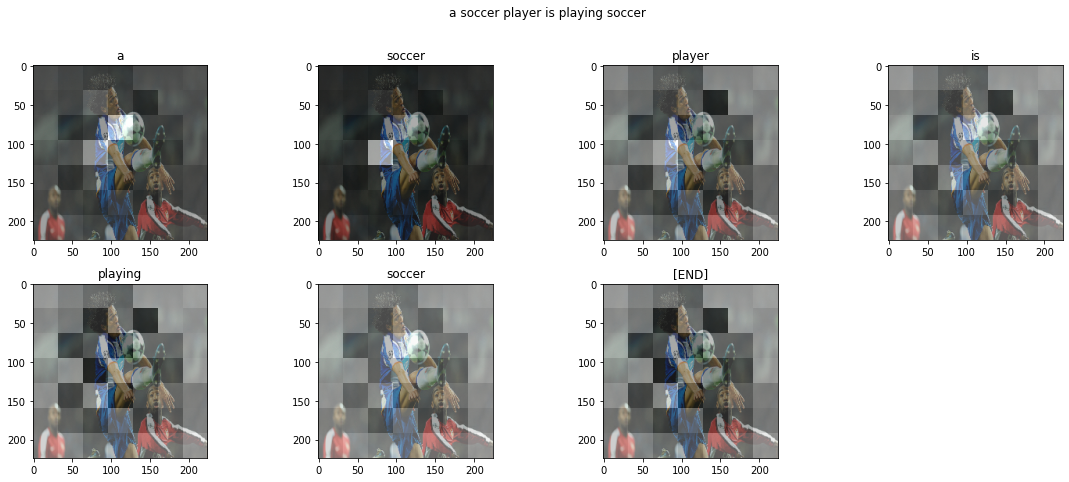

In [ ]:
image = load_image('/content/drive/MyDrive/NN_Team13_Lab3/image_dir/_1127412.jpg')
run_and_show_attention(model_final, image)

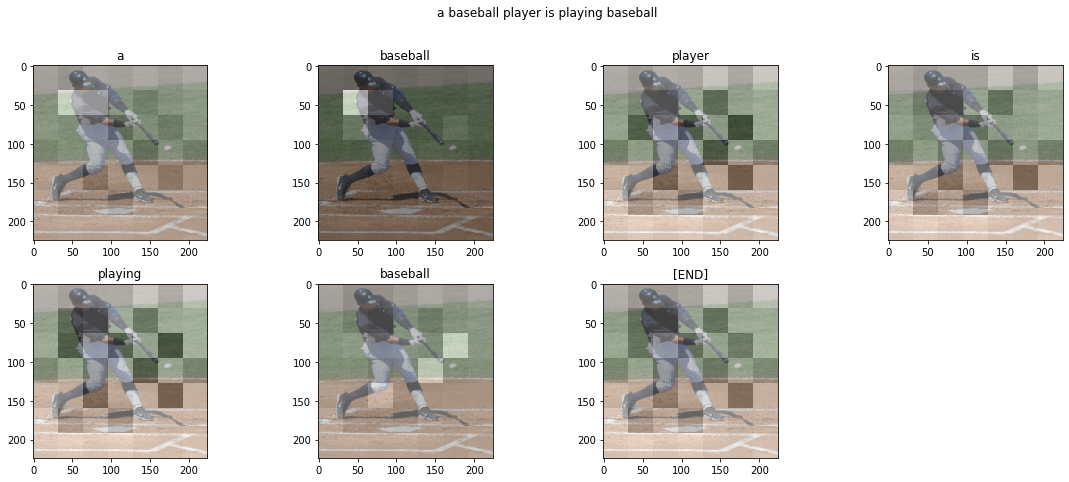

In [ ]:
image = load_image('/content/drive/MyDrive/NN_Team13_Lab3/image_dir/_1061948.jpg')
run_and_show_attention(model_final, image)

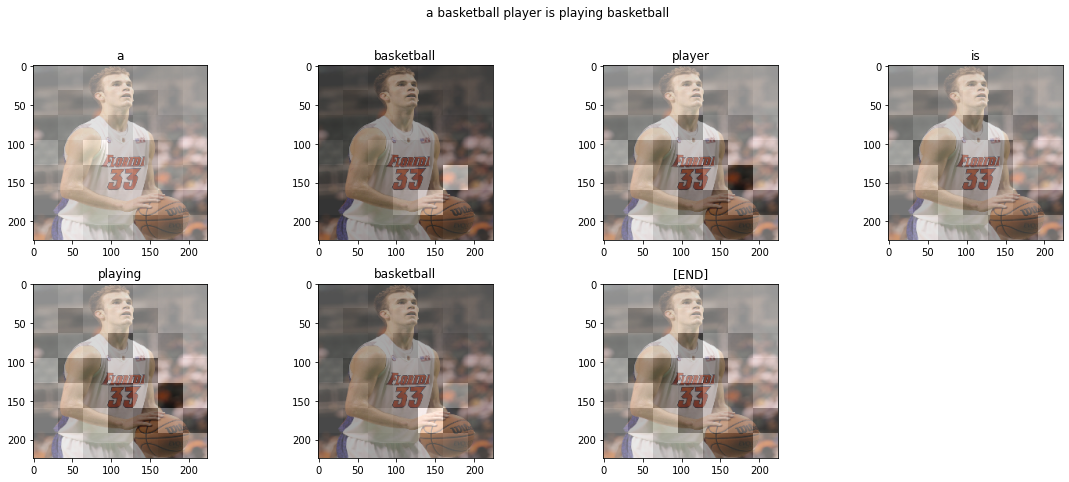

In [ ]:
image = load_image('/content/drive/MyDrive/NN_Team13_Lab3/image_dir/_1760374.jpg')
run_and_show_attention(model_final, image)

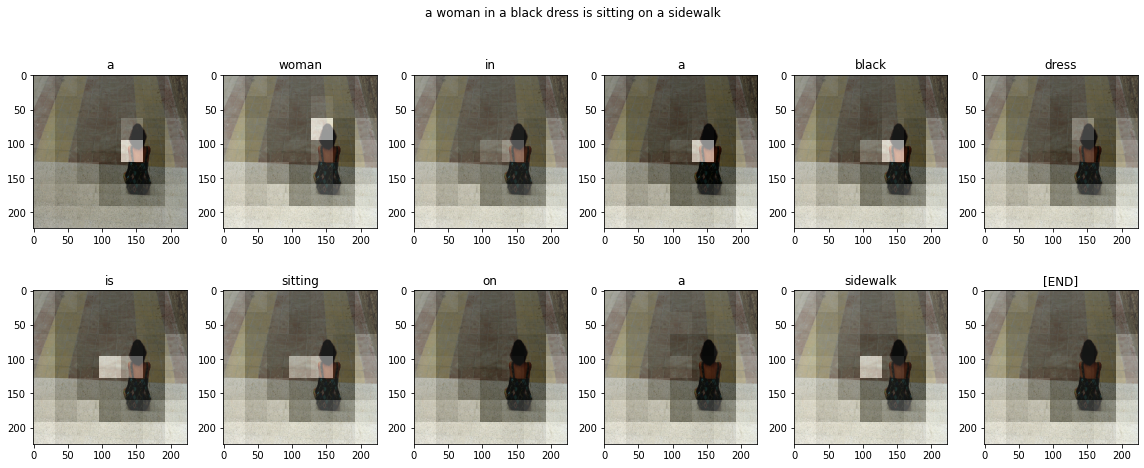

In [ ]:
image = load_image('/content/drive/MyDrive/NN_Team13_Lab3/image_dir/_2268786.jpg')
run_and_show_attention(model_final, image)

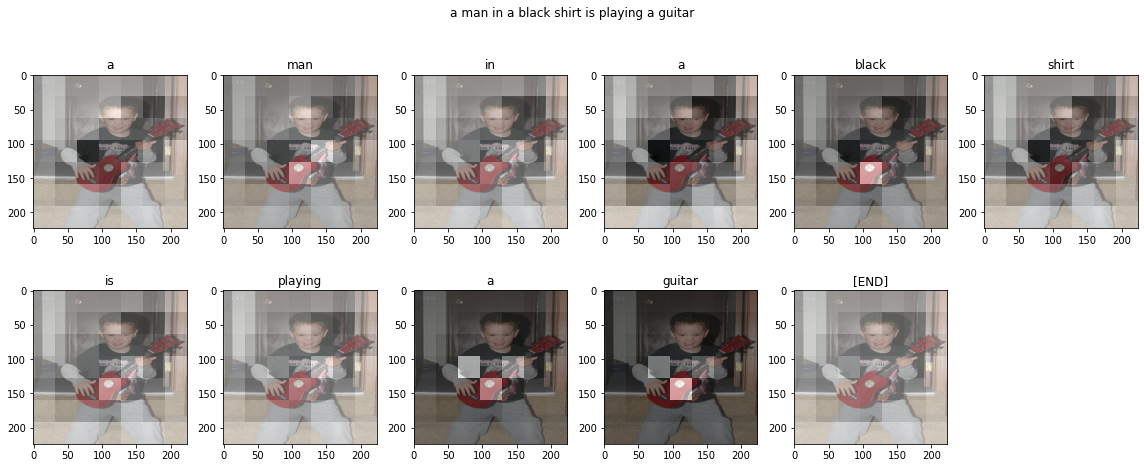

In [ ]:
image = load_image('/content/drive/MyDrive/NN_Team13_Lab3/image_dir/_4055420.jpg')
run_and_show_attention(model_final, image)

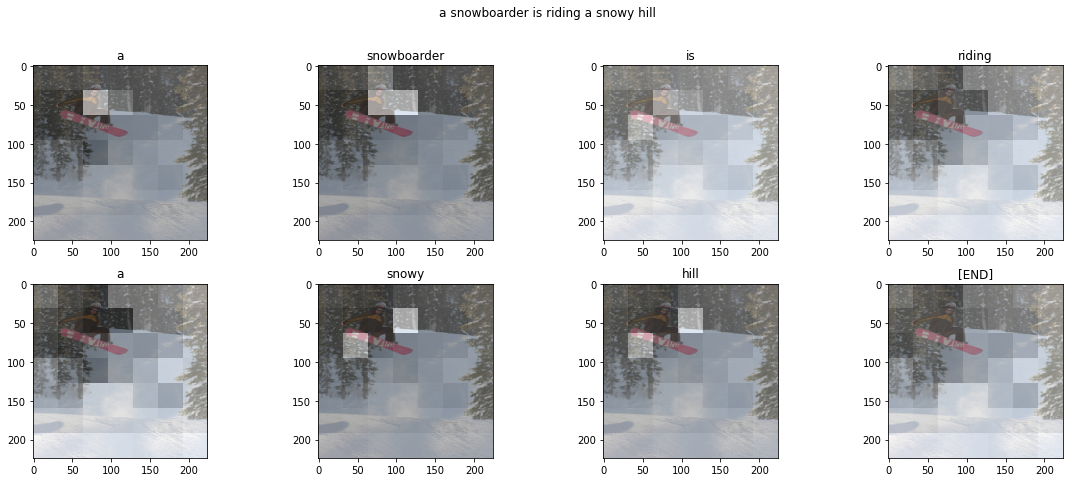

In [ ]:
image = load_image('/content/drive/MyDrive/NN_Team13_Lab3/image_dir/_219220.jpg')
run_and_show_attention(model_final, image)

**Nit Picking**

Βλέπουμε μερικές εικόνες στις οποίες το μοντέλο μας δεν αποδίδει καλά.

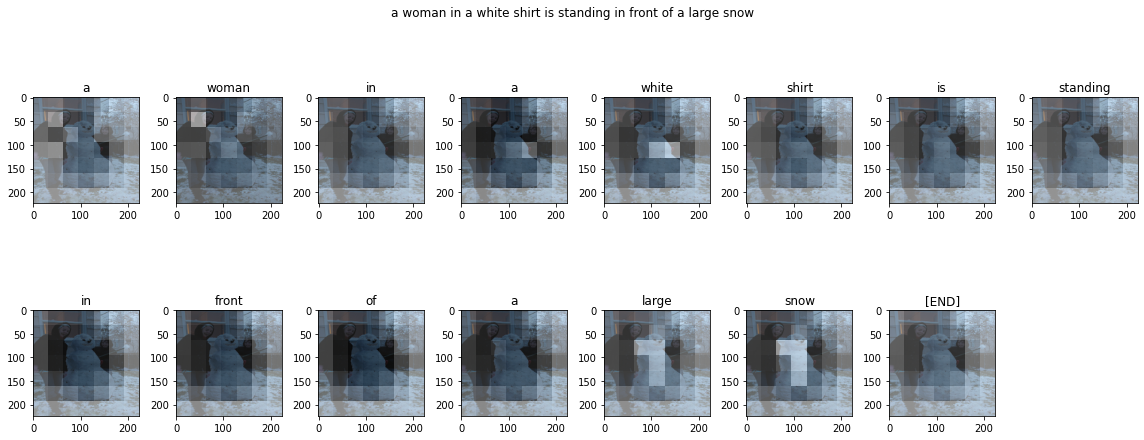

In [ ]:
image = load_image('/content/drive/MyDrive/NN_Team13_Lab3/image_dir/_4298724.jpg')
run_and_show_attention(model_final, image)

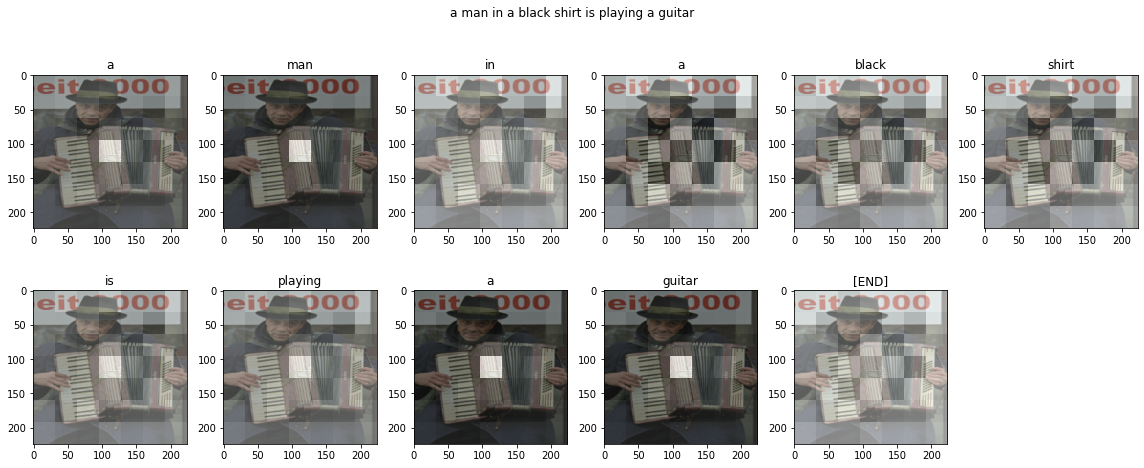

In [ ]:
image = load_image('/content/drive/MyDrive/NN_Team13_Lab3/image_dir/_4198935.jpg')
run_and_show_attention(model_final, image)

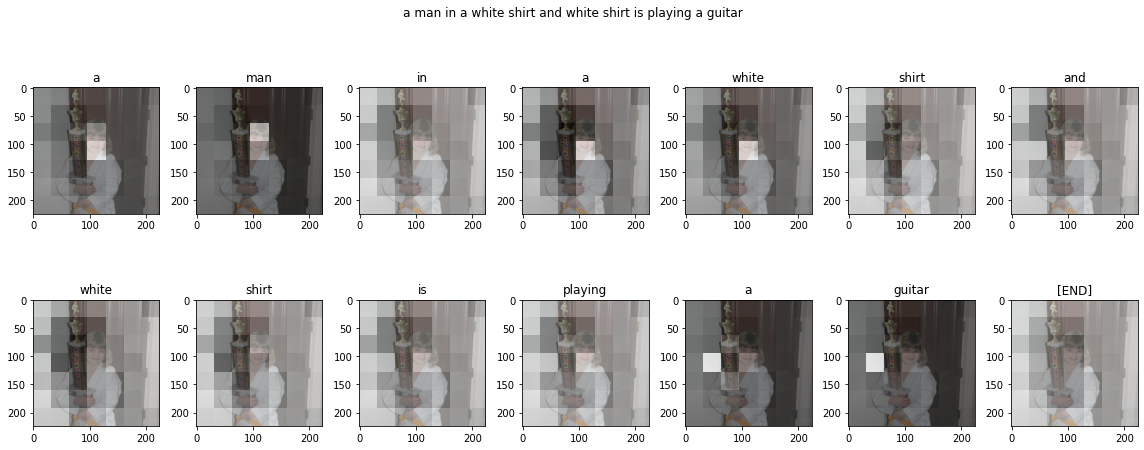

In [ ]:
image = load_image('/content/drive/MyDrive/NN_Team13_Lab3/image_dir/_2506608.jpg')
run_and_show_attention(model_final, image)

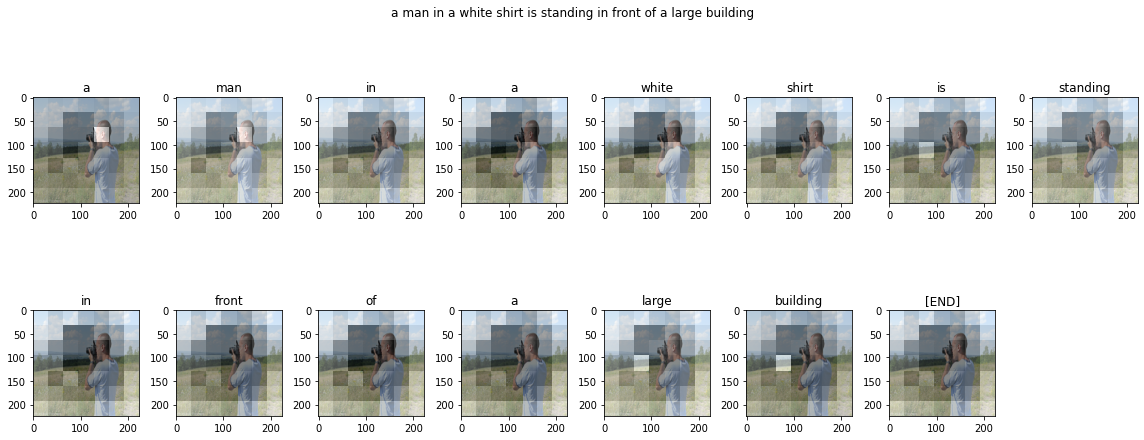

In [ ]:
image = load_image('/content/drive/MyDrive/NN_Team13_Lab3/image_dir/_3737654.jpg')
run_and_show_attention(model_final, image)

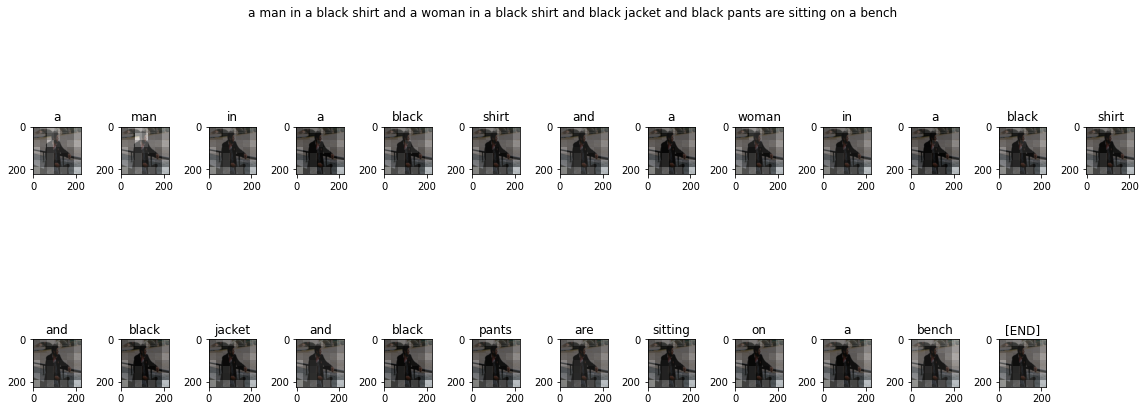

In [ ]:
image = load_image('/content/drive/MyDrive/NN_Team13_Lab3/image_dir/_4683456.jpg')
run_and_show_attention(model_final, image)